In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid , save_image
from boltzman_pytorch import *
%matplotlib inline

In [92]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RBM(k = 1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.05)
loss_fn.to(device)
model.to(device)
print(device)

cuda


In [122]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Grayscale()
])
handwritten_data = torchvision.datasets.ImageFolder("./data/handwrittendataset/Train/", transform)
dataloader = torch.utils.data.DataLoader(dataset=handwritten_data, batch_size = 2, shuffle = True)

In [123]:
rbm = RBM(k=1)
loss_boltzman = np.array(loss_boltzman)

for epoch in range(1):
    loss_ = []
    for i, (data,target) in enumerate(dataloader):
        data = Variable(data.view(data.size()[0],784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
            
    print(f"Total Data = {i}")
            
    loss_boltzman = np.append(loss_boltzman, np.mean(loss_))

Training loss for 0 epoch: 201.29074096679688
Training loss for 0 epoch: 232.6512451171875
Training loss for 0 epoch: 235.06634521484375
Training loss for 0 epoch: 234.8860321044922
Training loss for 0 epoch: 235.12005615234375
Training loss for 0 epoch: 234.9910430908203
Training loss for 0 epoch: 234.86968994140625
Training loss for 0 epoch: 234.9958953857422
Training loss for 0 epoch: 235.1533203125
Training loss for 0 epoch: 235.0968017578125
Training loss for 0 epoch: 235.27362060546875
Training loss for 0 epoch: 235.20420837402344
Training loss for 0 epoch: 235.28614807128906
Training loss for 0 epoch: 235.39901733398438
Training loss for 0 epoch: 235.63522338867188
Training loss for 0 epoch: 235.7266845703125
Training loss for 0 epoch: 235.69358825683594
Training loss for 0 epoch: 235.28504943847656
Training loss for 0 epoch: 235.19613647460938
Training loss for 0 epoch: 235.16293334960938
Training loss for 0 epoch: 235.1869354248047
Training loss for 0 epoch: 235.1509246826172


Training loss for 0 epoch: 235.36553955078125
Training loss for 0 epoch: 235.34584045410156
Training loss for 0 epoch: 235.3564910888672
Training loss for 0 epoch: 235.34762573242188
Training loss for 0 epoch: 235.3636016845703
Training loss for 0 epoch: 235.3501434326172
Training loss for 0 epoch: 235.36204528808594
Training loss for 0 epoch: 235.3807830810547
Training loss for 0 epoch: 235.36952209472656
Training loss for 0 epoch: 235.3596649169922
Training loss for 0 epoch: 235.3572998046875
Training loss for 0 epoch: 235.35501098632812
Training loss for 0 epoch: 235.35623168945312
Training loss for 0 epoch: 235.37091064453125
Training loss for 0 epoch: 235.36178588867188
Training loss for 0 epoch: 235.3441925048828
Training loss for 0 epoch: 235.33082580566406
Training loss for 0 epoch: 235.3260498046875
Training loss for 0 epoch: 235.33526611328125
Training loss for 0 epoch: 235.33583068847656
Training loss for 0 epoch: 235.33786010742188
Training loss for 0 epoch: 235.34877014160

Training loss for 0 epoch: 235.20108032226562
Training loss for 0 epoch: 235.20169067382812
Training loss for 0 epoch: 235.20347595214844
Training loss for 0 epoch: 235.20016479492188
Training loss for 0 epoch: 235.1974639892578
Training loss for 0 epoch: 235.19834899902344
Training loss for 0 epoch: 235.1986541748047
Training loss for 0 epoch: 235.20370483398438
Training loss for 0 epoch: 235.20526123046875
Training loss for 0 epoch: 235.20761108398438
Training loss for 0 epoch: 235.21080017089844
Training loss for 0 epoch: 235.20664978027344
Training loss for 0 epoch: 235.222412109375
Training loss for 0 epoch: 235.21444702148438
Training loss for 0 epoch: 235.21585083007812
Training loss for 0 epoch: 235.23106384277344
Training loss for 0 epoch: 235.2297821044922
Training loss for 0 epoch: 235.22813415527344
Training loss for 0 epoch: 235.2278289794922
Training loss for 0 epoch: 235.22962951660156
Training loss for 0 epoch: 235.22854614257812
Training loss for 0 epoch: 235.243164062

In [104]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

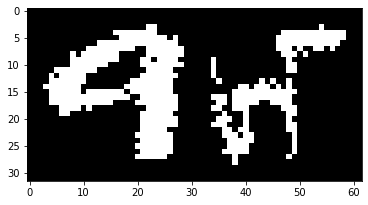

In [125]:
show_adn_save("real",make_grid(v.view(v.size()[0],1,28,28).data))

In [117]:
data_test


[tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.9320e-01,
            3.8892e-02, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.3670e-01,
            1.9320e-01, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]]],
 
 
         [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8305e-02,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 3.6011e-03, 6.1819e-02,  ..., 5.7917e-02,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00,

In [85]:
torch.save(rbm.state_dict(), "saved_models/rbm_nepali_characters.pth")